In [1]:
import json
import os
from pprint import pprint
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login


from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)

from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

from transformers import AutoTokenizer, AutoModelForCausalLM

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Loading the generic model (finetuned on Nvidia tech blogs)

In [2]:
PEFT_MODEL_gen = "FALCON7B_r32_a64_gen_tot"

config_gen = PeftConfig.from_pretrained(PEFT_MODEL_gen)

bnb_config = BitsAndBytesConfig(
    load_in_8bit = True
)


model_gen = AutoModelForCausalLM.from_pretrained(
    config_gen.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    # device_map=device_map,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
    # use_auth_token = True
)

tokenizer_gen = AutoTokenizer.from_pretrained(config_gen.base_model_name_or_path)
tokenizer_gen.pad_token = tokenizer_gen.eos_token

model_gen = PeftModel.from_pretrained(model_gen, PEFT_MODEL_gen)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Setting up the generation parameters 

In [3]:
generation_config_gen = model_gen.generation_config
generation_config_gen.max_new_tokens = 100
generation_config_gen.temperature = 0.005
generation_config_gen.top_p = 1
generation_config_gen.num_return_sequences = 1
generation_config_gen.pad_token_id = tokenizer_gen.eos_token_id
generation_config_gen.eos_token_id = tokenizer_gen.eos_token_id
generation_config_gen.repetition_penalty = 2.5

In [8]:
import pandas as pd

df = pd.read_csv("NVIDIA_QA_kit.csv")

del df["Unnamed: 0"]

In [9]:
from datasets import Dataset

eval_data = Dataset.from_pandas(df)

In [24]:
def generate_prompt(data_point):
    return f"""
    Answer the following question about Nvidea's product and services: \n\n{data_point["question"]}
    \n\nAnswer:-: {data_point["answer"]}
    """.strip()

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenizer_gen(full_prompt, padding=True, truncation=True)
    return tokenized_full_prompt


if tokenizer_gen.pad_token is None:
    tokenizer_gen.add_special_tokens({'pad_token': '[PAD]'})
    model_gen.resize_token_embeddings(len(tokenizer_gen))

In [26]:
eval_data = eval_data.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

In [32]:
# eval_data[0]

In [27]:
eval_data

Dataset({
    features: ['question', 'answer', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 164
})

In [13]:
%%time
device = "cuda:0"


# question = '''How can I install the
# NVIDIA CUDA Toolkit on
# Windows?'''

# question = '''What is the NVIDIA CUDA Toolkit?'''

# ans_true = '''The CUDA Toolkit from NVIDIA provides everything
# you need to develop GPU-accelerated applications.
# The CUDA Toolkit includes GPU-accelerated libraries,
# a
# compiler, development tools and the CUDA runtime.'''



question = '''What is the difference between
NVIDIA's BioMegatron and Megatron
530B LLM?'''

ans_true = '''BioMegatron focuses specifically on biomedical NLP
tasks and has been trained on relevant biomedical data,
Megatron 530B LLM is a more general-purpose
language model trained on a wide variety of text from
different domains. The choice between the two models
depends on the specific requirements and domain of your
NLP task.'''


prompt = f"""
Answer the following question about Nvidea's product and services in detail: \n{question}
\nAnswer:-
""".strip()



# prompt = """
# Answer the following question about Nvidea's product and services: What is NVIDEA's Omniverse? What is the purpose of it? Explain breifly \n\n
# \n\nAnswer:-:
# """.strip()

encoding = tokenizer_gen(prompt, return_tensors="pt").to(device)

CPU times: user 2.54 ms, sys: 1.13 ms, total: 3.67 ms
Wall time: 2.71 ms


In [16]:
def get_reponse(query, query_type):
    
    device = "cuda:0"
    
    prompt = f"""
        Answer the following question about Nvidia's product and services in detail: \n{query}
        \nAnswer:-
        """.strip()
    
    if query_type == "code":
        
        print("Code")

        
        encoding = tokenizer_code(prompt, return_tensors="pt").to(device)
        
        with torch.inference_mode():
            outputs = model_code.generate(
              input_ids = encoding.input_ids,
              attention_mask = encoding.attention_mask,
              generation_config = generation_config_code
          )
            
        response = tokenizer_code.decode(outputs[0], skip_special_tokens=True)
        
        
        return response
        


    elif query_type == "generic":
        
        print("Generic")
        
        encoding = tokenizer_gen(prompt, return_tensors="pt").to(device)
        
        with torch.inference_mode():
            outputs = model_gen.generate(
              input_ids = encoding.input_ids,
              attention_mask = encoding.attention_mask,
              generation_config = generation_config_gen
          )
            
        response = tokenizer_gen.decode(outputs[0], skip_special_tokens=True)
        
        
        return response
        
        
        
    else:
        print('''Please choose query_type to be one of these :- {"code", "generic"}''')
        return 
            
            
                    

In [17]:
generation_config_gen = model_gen.generation_config
generation_config_gen.max_new_tokens = 500
generation_config_gen.temperature = 0.005
generation_config_gen.top_p = 1
generation_config_gen.num_return_sequences = 1
generation_config_gen.pad_token_id = tokenizer_gen.eos_token_id
generation_config_gen.eos_token_id = tokenizer_gen.eos_token_id
generation_config_gen.repetition_penalty = 2.5


# op = get_reponse(query = ''' What is Nvidia RAPIDS? what is it used for? '''
            
#             , query_type = "generic")


query = "How to install NVIDIA on vmware?"

op = get_reponse(query = query
            
            , query_type = "generic")



Generic


In [18]:
print(op)

Answer the following question about Nvidia's product and services in detail: 
How to install NVIDIA on vmware?
        
Answer:-: To install NVIDIA drivers for Linux guests, you must first enable virtualization support in your VMware Workstation or Fusion settings. Then download and run the installer package from nvidia.com/drivers. After installation, reboot your virtual machine. Once it restarts, log into GNOME Shell as root with sudo su -c sh -e '/usr/bin/nvdia_installer'. This will launch a graphical user interface that guides you through installing CUDA Toolkit components. You can also use this method to update existing installations of CUDA software packages.


In [55]:

question = '''What are the key features of the NVIDIA TensorRT?'''

ans_true = '''NVIDIA TensorRT, an SDK for high-performance
deep learning inference, includes a deep learning
inference optimizer and runtime that delivers low
latency and high throughput for inference
applications.Some key features of TensorRT include:
- NVIDIA TensorRT-based applications perform up
to 36X faster than CPU-only platforms during
inference, enabling you to optimize neural network
models
- TensorRT, built on the NVIDIA CUDA®
parallel programming model, enables you to optimize
inference using techniques such as quantization, layer
and tensor fusion, kernel tuning, and others on
NVIDIA GPUs.'''

In [53]:
query = "What are the key features of the NVIDIA TensorRT?"

op = get_reponse(query = query
            
            , query_type = "generic")

print(op)

Generic
Answer the following question about Nvidia's product and services in detail: 
What are the key features of the NVIDIA TensorRT?
        
Answer:-: The NVIDIA® TensorRT™ inference engine is a high-performance, production ready library that accelerates deep learning inferencing on GPUs. It provides optimized implementations for popular neural networks such as ResNet50V2, MobileNetsv2/3, Inception v4, XGBoost, DensePose, etc., with support for multiple backends including CUDA, OpenCL, DirectX Compute Shaders, Intel SGDR, Microsoft CUDNN, Arm NNAPI, Apple Metal MLCompute API, Google Cloud TPU Accelerator, AWS Nitro Enclave SDK, Azure Cognitive Services REST APIs, and more.


In [56]:
ans_true

'NVIDIA TensorRT, an SDK for high-performance\ndeep learning inference, includes a deep learning\ninference optimizer and runtime that delivers low\nlatency and high throughput for inference\napplications.Some key features of TensorRT include:\n- NVIDIA TensorRT-based applications perform up\nto 36X faster than CPU-only platforms during\ninference, enabling you to optimize neural network\nmodels\n- TensorRT, built on the NVIDIA CUDA®\nparallel programming model, enables you to optimize\ninference using techniques such as quantization, layer\nand tensor fusion, kernel tuning, and others on\nNVIDIA GPUs.'

In [33]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from rouge import Rouge

def eval_query(prediction, output):
    
    rouge = Rouge()
    rouge_scores = rouge.get_scores(prediction, output)[0]
    rouge_1 = rouge_scores['rouge-1']['f']
    rouge_2 = rouge_scores['rouge-2']['f']
    rouge_l = rouge_scores['rouge-l']['f']

    
    return [rouge_1,rouge_2,rouge_l]

In [41]:
def get_scores(eval_data):
    
    r1_scores = []
    r2_scores = []
    rL_scores = []
    
    for i in range(len(eval_data)):

        question = eval_data[i]["question"]
        
        prompt = f"""
        Answer the following question about Nvidea's product and services in detail: \n{question}
        \nAnswer:-
        """.strip()

        encoding = tokenizer_gen(prompt, return_tensors="pt").to(device)

        outputs = model_gen.generate(
          input_ids = encoding.input_ids,
          attention_mask = encoding.attention_mask,
          generation_config = generation_config_gen
      )
        
        prediction = tokenizer_gen.decode(outputs[0], skip_special_tokens=True)
        
        output = eval_data[i]["answer"]
    
        rouge_1,rouge_2,rouge_l = eval_query(prediction, output)
        
        r1_scores.append(rouge_1)
        r2_scores.append(rouge_2)
        rL_scores.append(rouge_l)
        
        
    return [r1_scores,r2_scores,rL_scores]
        
        

In [42]:
%%time
scores = get_scores(eval_data)

CPU times: user 20min 41s, sys: 95.2 ms, total: 20min 41s
Wall time: 20min 41s


[[0.16867469388300205,
  0.18181817884297521,
  0.17999999533800012,
  0.18181817904040404,
  0.37894736371412746,
  0.270270266092038,
  0.2888888840098766,
  0.0941176446339101,
  0.25974025629954467,
  0.2666666622222223,
  0.13999999745000002,
  0.15730336742835507,
  0.2702702658875092,
  0.23404254949524675,
  0.3055555510223766,
  0.20930232127366155,
  0.25641025191029304,
  0.285714281044898,
  0.28865978939313425,
  0.3181818136182852,
  0.19753085925925937,
  0.21428571010487535,
  0.34090908611828513,
  0.23255813492428348,
  0.35416666253472223,
  0.30136985916307,
  0.2619047572477325,
  0.2799999958,
  0.33734939320075485,
  0.31884057479521116,
  0.268041233095972,
  0.30434782120274106,
  0.357142852244898,
  0.17204300646086262,
  0.34666666192355555,
  0.27083332870008686,
  0.3218390756084027,
  0.10833333120868059,
  0.3076923034319527,
  0.27499999537812503,
  0.2666666624666667,
  0.29999999537812505,
  0.32558139143050296,
  0.4155844107741609,
  0.2857142814539

In [44]:
r1_scores = scores[0]
r2_scores = scores[1]
rl_scores = scores[2]

/dgxa_home/se20uari038/anaconda3/envs/mowa/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x500 with 0 Axes>

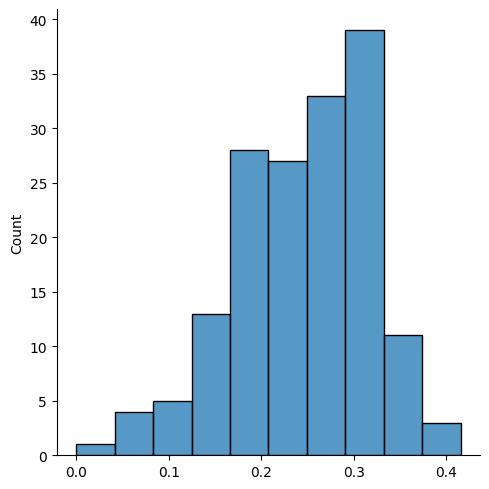

In [48]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))
sns.displot(r1_scores)
# plt.plot()

/dgxa_home/se20uari038/anaconda3/envs/mowa/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


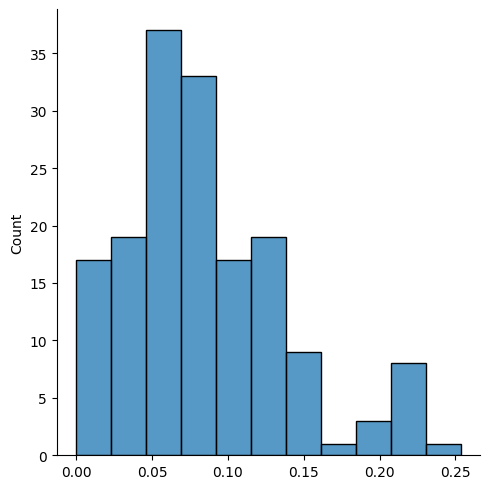

In [49]:
sns.displot(r2_scores)


/dgxa_home/se20uari038/anaconda3/envs/mowa/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


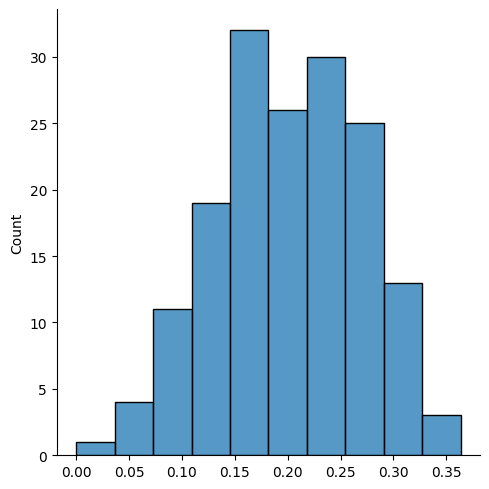

In [50]:
sns.displot(rl_scores)

In [58]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)


In [60]:
def get_f1_scores(eval_data):
    
    f1_scores = []
    
    true_ans = []
    pred_ans = []
    
    for i in range(len(eval_data)):

        question = eval_data[i]["question"]
        
        prompt = f"""
        Answer the following question about Nvidea's product and services in detail: \n{question}
        \nAnswer:-
        """.strip()

        encoding = tokenizer_gen(prompt, return_tensors="pt").to(device)

        outputs = model_gen.generate(
          input_ids = encoding.input_ids,
          attention_mask = encoding.attention_mask,
          generation_config = generation_config_gen
      )
        
        prediction = tokenizer_gen.decode(outputs[0], skip_special_tokens=True)
        
        output = eval_data[i]["answer"]
    
        f1 = compute_f1(prediction, output)
        
        true_ans.append(output)
        pred_ans.append(prediction)
        
        
        f1_scores.append(f1)
        
        
    return [f1_scores, true_ans, pred_ans]
        
        

In [63]:
%%time

f1_scores,true_ans,pred_ans = get_f1_scores(eval_data)

CPU times: user 20min 36s, sys: 177 ms, total: 20min 36s
Wall time: 20min 37s


In [66]:
np.array(f1_scores).mean()

0.2103319580116902

In [68]:
np.array(f1_scores).max()

0.375

In [69]:
np.array(f1_scores).min()

0.0

/dgxa_home/se20uari038/anaconda3/envs/mowa/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


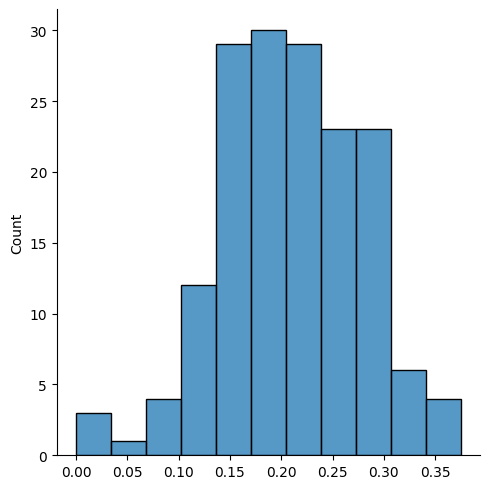

In [70]:
sns.displot(f1_scores)